<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Convolutions/Architecture_styles_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Architecture styles

We're going to use kaggle dataset for architecture styles

## Imports and installations

In [ ]:
%%capture
!pip install kaggle

In [3]:
import albumentations as A
import numpy as np
import os

from albumentations.pytorch import ToTensorV2
from IPython.display import clear_output
from PIL import Image
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

In [4]:
!kaggle datasets download -d dumitrux/architectural-styles-dataset

 99% 1.54G/1.56G [00:16<00:00, 90.2MB/s]
100% 1.56G/1.56G [00:17<00:00, 98.5MB/s]


In [ ]:
!unzip architectural-styles-dataset.zip
clear_output(wait=True)

## Dataset preparation

Create config

In [22]:
class CFG:
  train_perc = 0.8
  test_val_perc = 0.5
  batch_size = 32
  epochs = 5

In [8]:
basic_augs = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()])

In [72]:
class ArchitecturalStylesDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir))
        self.label2name = {label: class_name for label, class_name in enumerate(self.classes)}

        self.files = []
        for class_name in self.classes:
            class_dir = os.path.join(data_dir, class_name)
            extended_list = [(os.path.join(class_dir, fname), class_name) for fname in os.listdir(class_dir)]
            self.files.extend(extended_list)
            print(class_name, self.files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, class_name = self.files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.classes.index(class_name)
        if self.transform:
            augmented = self.transform(image=np.array(image))
            image = augmented['image']
        return image, label

In [74]:
%%capture
dataset = ArchitecturalStylesDataset(data_dir='architectural-styles-dataset1', transform=basic_augs)

In [76]:
print("Class Name to Integer Label Mapping:")
for key, value in dataset.label2name.items():
    print(f"{key}: {value}")

Class Name to Integer Label Mapping:
0: Achaemenid architecture
1: American Foursquare architecture
2: American craftsman style
3: Ancient Egyptian architecture
4: Art Deco architecture
5: Art Nouveau architecture
6: Baroque architecture
7: Bauhaus architecture
8: Beaux-Arts architecture
9: Byzantine architecture
10: Chicago school architecture
11: Colonial architecture
12: Deconstructivism
13: Edwardian architecture
14: Georgian architecture
15: Gothic architecture
16: Greek Revival architecture
17: International style
18: Novelty architecture
19: Palladian architecture
20: Postmodern architecture
21: Queen Anne architecture
22: Romanesque architecture
23: Russian Revival architecture
24: Tudor Revival architecture


#### Split into train and val datasets

In [77]:
train_size = int(CFG.train_perc * len(dataset))
test_val_size = len(dataset) - train_size
train_data, test_val_data = random_split(dataset, [train_size, test_val_size])

#### Add more augs to train dataset

In [78]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=30, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()])


In [79]:
train_data.dataset.transform = train_transform

#### Split val into val and test

In [80]:
val_size = int(CFG.test_val_perc * len(test_val_data))
test_size = len(test_val_data) - val_size
val_data, test_data = random_split(test_val_data, [val_size, test_size])

#### Create dataloaders

In [81]:
train_loader = DataLoader(train_data, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=CFG.batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=CFG.batch_size, shuffle=False)

In [31]:
import matplotlib.pyplot as plt

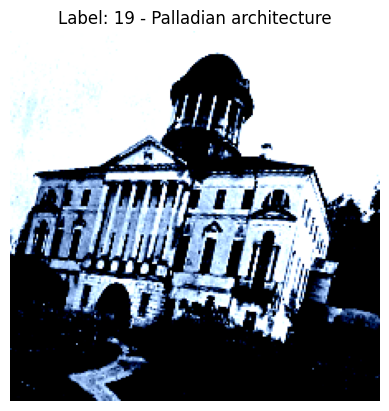

In [102]:
img, label = next(iter(train_loader))
img, label = img[0],label[0]
labelname = dataset.label2name[int(label)]
image_np = img.permute(1, 2, 0).numpy()

plt.imshow(image_np)
plt.title(f"Label: {label} - {labelname}")
plt.axis('off')
plt.show()